In [44]:
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageDraw, ImageFont
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

from skimage import feature, data, color
from glob import glob # Used to easily find file paths
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, auc


In [45]:
# Loud the data folder and the images
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"

all_images = []
all_labels = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]

        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)

            labels = record['CANCER'].iloc[0]

            all_images.append(img_array)
            all_labels.append(labels)

print("Besham ta alan ke chedesh ...")

Besham ta alan ke chedesh ...


In [46]:
print(f"Image list {len(all_images)}")
print(f"Labels list {len(all_labels)}")
df.head(5)

Image list 324
Labels list 324


,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,CANCER
0,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,0
1,mdb001,G,CIRC,B,535,425,197,1
2,mdb002,G,CIRC,B,522,280,69,1
3,mdb003,D,NORM,NaN,NaN,NaN,NaN,0
4,mdb004,D,NORM,NaN,NaN,NaN,NaN,0


In [47]:
# img = cv2.imread('all-mias/mdb005.pgm', cv2.IMREAD_GRAYSCALE)
# print(img.shape, img.dtype)
# img.max()
# plt.imshow(img, cmap='gray')

In [48]:

normalaized_img = [] # holding the LBP maps
print("Computing the image and histogram for pooling and classification...")

for img in all_images:
    # Normalazing the image 
    if img.max() > img.min():
        n_img = ((img - img.min()) / (img.max() - img.min()) * 255) 
    else:
        n_img = img
    # normalaized_img.append(n_img)
    P = 8
    R = 3
    method = 'uniform'
    LBP = feature.local_binary_pattern(n_img, P, R, method)

#     bins_num = int(n_img.max()) + 1
    normalaized_img.append(LBP)
# print(LBP.min())

print("Normalazation process has been Done!.")

print("Start of the histogram processing...")
def compute_histograms_for_each_region(normalaized_img, G=6, n_bins=59):
    #compute th histogram from 255 in image size to 59 =>  reduce the number of bins
    histogram = []
#     # Pooling the image in to 6 x 6
#     H = 1020 # height
#     W = 1020 # width
#     #G = 6 # Number of Grid 6 * 6 
#     hor = int(H / G) # height of each region
#     wor = int(W / G) # width of each region
    H, W = normalaized_img.shape
    hor, wor = H // G, W // G
# Pooling the data into 6 * 6 regions
    for i in range(G):
        for j in range(G):
            row_start = i * hor
            row_end = (i + 1) * hor
            col_start = j * wor
            col_end = (i + 1) * wor
            region = normalaized_img[row_start:row_end, col_start:col_end]

            hist, _ = np.histogram(region.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype(float)
            if hist.sum() > 0:    
                hist /= hist.sum()
        
            histogram.append(hist)

    return histogram
x_list = []
y_list = []
for lbp_img, label in zip(normalaized_img, all_labels):
    histogram = compute_histograms_for_each_region(lbp_img)

    f_vector = np.concatenate(histogram)
    f_vector /= np.linalg.norm(f_vector) + 1e-10
#     print(f_vector.shape)

    x_list.append(f_vector)
    y_list.append(label)

X = np.array(x_list)
y = np.array(y_list)

# print(hor)

print("Function has been done successfully")

Computing the image and histogram for pooling and classification...
Normalazation process has been Done!.
Start of the histogram processing...
Function has been done successfully


In [49]:
unique_codes = np.unique(LBP)
print("Unique LBP codes in this image:", unique_codes)

Unique LBP codes in this image: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,    # for reproducibility
    stratify=y          # preserves class ratios
)

In [51]:
rf_model = RandomForestClassifier(
    n_estimators=250,
    class_weight = 'balanced',
    max_depth=None,
    min_samples_split=10,
    random_state=65,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 5. Predict
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)  # if you need probabilities


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57        42
           1       0.11      0.09      0.10        23

    accuracy                           0.42        65
   macro avg       0.32      0.34      0.33        65
weighted avg       0.39      0.42      0.40        65

Confusion Matrix:
[[25 17]
 [21  2]]


Recall (sensitivity): 0.087
AUC: 0.304


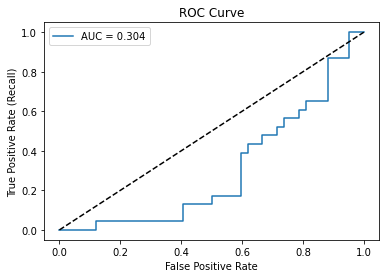

In [53]:
from sklearn.metrics import recall_score, roc_auc_score, roc_curve

# 1. Get the probability for the positive class (cancer = 1)
y_prob_pos = y_prob[:, 1]

# 2. Apply your threshold (0.5) to get 1D predictions
y_pred = (y_prob_pos >= 0.5).astype(int)

# 3. Compute recall
recall = recall_score(y_test, y_pred)
print(f"Recall (sensitivity): {recall:.3f}")

# 4. Compute AUC
auc_score = roc_auc_score(y_test, y_prob_pos)
print(f"AUC: {auc_score:.3f}")

# 5. (Optional) Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_pos)
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming 'X' and 'y' are your feature matrix and labels from the previous script
# X = np.array(x_list)
# y = np.array(y_list)

# 1. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2. Scale the features
# Create the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Training set shape: (226, 2124)
Test set shape: (98, 2124)


In [57]:
from sklearn.svm import SVC

# --- Create and Train the SVM Model ---
# We use the RBF kernel, which is a good default choice.
# C is the regularization parameter.
# 'probability=True' is needed to calculate ROC AUC score.
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)

print("Training the SVM model...")
svm_model.fit(X_train_scaled, y_train)
print("Training complete.")

# --- Make Predictions on the Test Set ---
y_pred_svm = svm_model.predict(X_test_scaled)

# --- Evaluate the Model ---
print("\n--- SVM Model Evaluation ---")
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy: {accuracy_svm:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['No Cancer (0)', 'Cancer (1)']))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

# Calculate and print the ROC AUC score
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1] # Get probabilities for the positive class
auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"\nAUC Score: {auc_svm:.4f}")

Training the SVM model...
Training complete.

--- SVM Model Evaluation ---
Accuracy: 0.6020

Classification Report:
               precision    recall  f1-score   support

No Cancer (0)       0.63      0.94      0.75        63
   Cancer (1)       0.00      0.00      0.00        35

     accuracy                           0.60        98
    macro avg       0.31      0.47      0.38        98
 weighted avg       0.40      0.60      0.48        98


Confusion Matrix:
[[59  4]
 [35  0]]

AUC Score: 0.4172


In [58]:
from sklearn.model_selection import GridSearchCV

# --- Hyperparameter Tuning using GridSearchCV ---
print("\n--- Tuning SVM Hyperparameters with GridSearchCV ---")

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'gamma': ['scale', 0.1, 0.01, 0.001], # Kernel coefficient
    'kernel': ['rbf']
}

# Create a GridSearchCV object
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, verbose=2, scoring='roc_auc')

# Fit it to the training data
grid_search.fit(X_train_scaled, y_train)

# --- Get the Best Model ---
print("\nBest parameters found: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

# --- Evaluate the Best Found Model ---
y_pred_best_svm = best_svm_model.predict(X_test_scaled)
y_prob_best_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]

print("\n--- Evaluation of a Tuned SVM Model ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_svm):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_best_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_svm, target_names=['No Cancer (0)', 'Cancer (1)']))


--- Tuning SVM Hyperparameters with GridSearchCV ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] .................... C=10, gamma=0.001, kernel=rbf, total=   0.1s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=100, gamma=scale, kernel=rbf ..................................
[CV] ................... C=100, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   11.4s finished



Best parameters found:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

--- Evaluation of a Tuned SVM Model ---
Accuracy: 0.4592
AUC Score: 0.3556

Classification Report:
               precision    recall  f1-score   support

No Cancer (0)       0.59      0.51      0.55        63
   Cancer (1)       0.30      0.37      0.33        35

     accuracy                           0.46        98
    macro avg       0.44      0.44      0.44        98
 weighted avg       0.49      0.46      0.47        98




--- Finding the optimal 'k' for K-NN ---


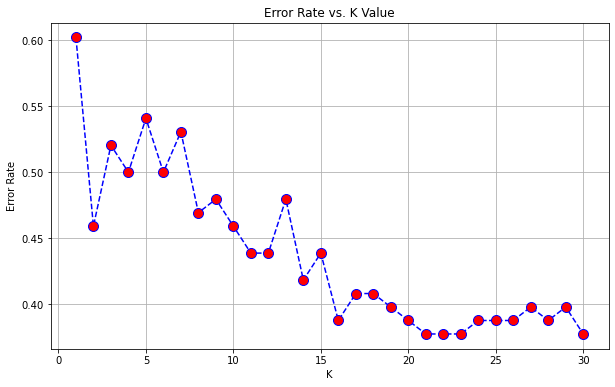

Optimal 'k' found: 21

Training the K-NN model with optimal 'k'...
Training complete.

--- K-NN Model Evaluation (k=21) ---
Accuracy: 0.6224

Classification Report:
               precision    recall  f1-score   support

No Cancer (0)       0.64      0.92      0.76        63
   Cancer (1)       0.38      0.09      0.14        35

     accuracy                           0.62        98
    macro avg       0.51      0.50      0.45        98
 weighted avg       0.55      0.62      0.54        98


Confusion Matrix:
[[58  5]
 [32  3]]

AUC Score: 0.4760


In [59]:
from sklearn.neighbors import KNeighborsClassifier

# --- Find the Best 'k' ---
print("\n--- Finding the optimal 'k' for K-NN ---")

error_rate = []
k_range = range(1, 31) # Test k from 1 to 30

for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    # Calculate error rate and append to the list
    error_rate.append(np.mean(pred_i != y_test))

# Plot the error rate to find the 'elbow'
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# Find the k with the minimum error
best_k = k_range[np.argmin(error_rate)]
print(f"Optimal 'k' found: {best_k}")


# --- Create and Train the Final K-NN Model with the Best 'k' ---
knn_model = KNeighborsClassifier(n_neighbors=best_k)

print("\nTraining the K-NN model with optimal 'k'...")
knn_model.fit(X_train_scaled, y_train)
print("Training complete.")


# --- Make Predictions ---
y_pred_knn = knn_model.predict(X_test_scaled)

# --- Evaluate the Model ---
print(f"\n--- K-NN Model Evaluation (k={best_k}) ---")
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['No Cancer (0)', 'Cancer (1)']))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Calculate and print the ROC AUC score
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1] # Get probabilities
auc_knn = roc_auc_score(y_test, y_prob_knn)
print(f"\nAUC Score: {auc_knn:.4f}")

In [107]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.svm            import SVC
from sklearn.metrics        import classification_report, confusion_matrix, roc_auc_score

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2. Scale features (fit on train, apply to both)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3. Instantiate SVM
svm = SVC(
    kernel='rbf',    # radial basis function
    C=1.0,           # regularization parameter
    gamma='scale',   # 1 / (n_features * X.var())
    probability=True,# if you need predict_proba()
    random_state=42
)

# 4. Train
svm.fit(X_train_scaled, y_train)

# 5. Predict
y_pred = svm.predict(X_test_scaled)
y_prob = svm.predict_proba(X_test_scaled)[:, 1]  # for binary or one‑vs‑rest

# 6. Evaluate
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
try:
    print("ROC AUC:", roc_auc_score(y_test, y_prob, multi_class='ovr'))
except:
    pass

# 7. (Optional) Hyperparameter tuning
param_grid = {
    'C':     [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(
    svm, param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)
print("Best SVM params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# After tuning, you can re‑evaluate the best model:
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
print("Tuned SVM report:\n", classification_report(y_test, y_pred_best))


C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.65      1.00      0.79        42
           1       0.00      0.00      0.00        23

    accuracy                           0.65        65
   macro avg       0.32      0.50      0.39        65
weighted avg       0.42      0.65      0.51        65

Confusion Matrix:
 [[42  0]
 [23  0]]
ROC AUC: 0.5
Best SVM params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.49588881706528765
Tuned SVM report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79        42
           1       0.00      0.00      0.00        23

    accuracy                           0.65        65
   macro avg       0.32      0.50      0.39        65
weighted avg       0.42      0.65      0.51        65



C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Generating placeholder data for demonstration...
Data shape: X=(212, 2124), y=(212,)

Data successfully split and scaled.
Training set shape: (148, 2124)
Test set shape: (64, 2124)

--- Training Support Vector Machine (SVM) ---
Searching for the best SVM hyperparameters...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=scale, kernel=rbf ..................................
[CV] ................... C=0.1, gamma=scale, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.1s finished


Optimal 'k' found: 17


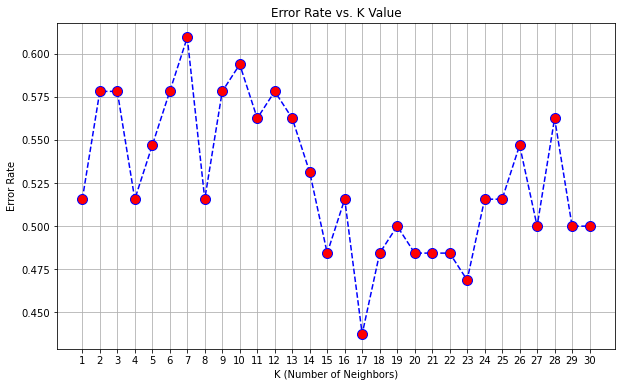


--- K-NN Model Evaluation (k=17) ---
Accuracy: 0.5625
AUC Score: 0.5205

Classification Report:
               precision    recall  f1-score   support

No Cancer (0)       0.56      0.59      0.58        32
   Cancer (1)       0.57      0.53      0.55        32

     accuracy                           0.56        64
    macro avg       0.56      0.56      0.56        64
 weighted avg       0.56      0.56      0.56        64


Confusion Matrix:
[[19 13]
 [15 17]]


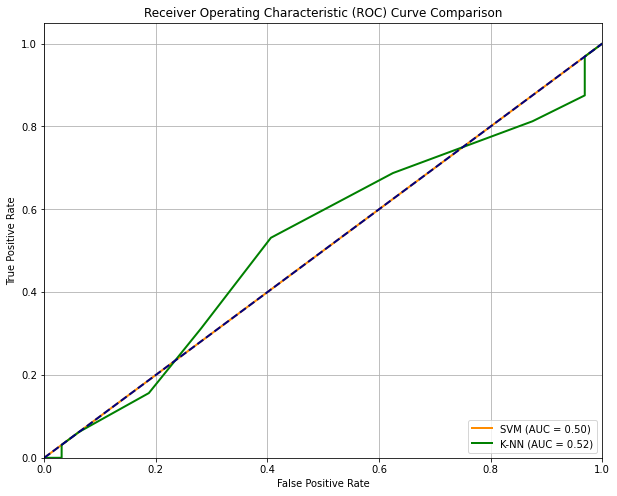

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# --- 1. Load Your Data ---
# Replace this section with your actual data loading.
# For demonstration purposes, I'm creating placeholder data
# with the same structure you would have.
#
# EXAMPLE:
# X = np.array(x_list)  # Your feature vectors from the previous script
# y = np.array(y_list)  # Your labels (0 or 1)

# Placeholder data (REMOVE THIS WHEN USING YOUR OWN DATA)
print("Generating placeholder data for demonstration...")
# Generating 212 samples with 2124 features each (36 regions * 59 bins)
num_samples = 212
num_features = 36 * 59
X = np.random.rand(num_samples, num_features)
y = np.random.randint(0, 2, num_samples)
print(f"Data shape: X={X.shape}, y={y.shape}\n")


# --- 2. Split Data and Scale Features ---
# This is a critical step for both SVM and K-NN.

# Split data into training (70%) and testing (30%) sets.
# 'stratify=y' ensures the proportion of classes is the same in train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Feature Scaling
# We fit the scaler ONLY on the training data to prevent data leakage from the test set.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Apply the same transformation to the test set

print("Data successfully split and scaled.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}\n")


# --- 3. Support Vector Machine (SVM) ---
print("--- Training Support Vector Machine (SVM) ---")

# Use GridSearchCV to find the best hyperparameters (C and gamma)
# This is the recommended approach for getting the best performance from an SVM.
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization parameter
    'gamma': ['scale', 0.1, 0.01],   # Kernel coefficient for 'rbf'
    'kernel': ['rbf']                # We will use the Radial Basis Function kernel
}

# We use 5-fold cross-validation and score based on roc_auc
# verbose=2 shows the progress
grid_search_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=2
)

print("Searching for the best SVM hyperparameters...")
grid_search_svm.fit(X_train_scaled, y_train)

# Get the best model found by the grid search
best_svm_model = grid_search_svm.best_estimator_
print(f"\nBest SVM parameters found: {grid_search_svm.best_params_}")

# Evaluate the best SVM model on the test data
print("\n--- SVM Model Evaluation ---")
y_pred_svm = best_svm_model.predict(X_test_scaled)
y_prob_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1] # Probabilities for the positive class

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['No Cancer (0)', 'Cancer (1)']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


# --- 4. K-Nearest Neighbors (K-NN) ---
print("\n\n--- Training K-Nearest Neighbors (K-NN) ---")

# First, we need to find the optimal number of neighbors ('k')
error_rate = []
k_range = range(1, 31) # We'll test k from 1 to 30

print("Finding the optimal 'k' for K-NN...")
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    pred_k = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_k != y_test))

# Find the k with the minimum error rate
best_k = k_range[np.argmin(error_rate)]
print(f"Optimal 'k' found: {best_k}")

# Plot the error rate vs. k to visualize the 'elbow'
plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Train the final K-NN model using the best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

# Evaluate the final K-NN model
print(f"\n--- K-NN Model Evaluation (k={best_k}) ---")
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Print evaluation metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"AUC Score: {roc_auc_score(y_test, y_prob_knn):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=['No Cancer (0)', 'Cancer (1)']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))


# --- 5. Compare Models with ROC Curves ---
# An ROC curve shows the performance of a classifier at all classification thresholds.

# Calculate ROC curve data
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2,
         label=f'SVM (AUC = {roc_auc_score(y_test, y_prob_svm):.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2,
         label=f'K-NN (AUC = {roc_auc_score(y_test, y_prob_knn):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Dashed line for random chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [105]:
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))
# axes[0].imshow(n_img, cmap='gray')
# axes[0].set_title("Original")
# axes[0].axis('off')

# axes[1].imshow(LBP, cmap='gray')
# axes[1].set_title(f"LBP (P={P}, R={R})")
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

In [117]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load Data (Your existing code, which is correct) ---
print("Loading and preparing data...")
col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
df = pd.read_csv('data2.txt', sep="\s+", names=col_names, header=None)
df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

images_path = "all-mias"
all_images = []
all_labels = []

for filename in sorted(os.listdir(images_path)):
    if filename.lower().endswith('.pgm'):
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]
        if not record.empty:
            full_path = os.path.join(images_path, filename)
            img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
            labels = record['CANCER'].iloc[0]
            all_images.append(img_array)
            all_labels.append(labels)
print("Data loading complete.")

# --- 2. Corrected LBP Feature Extraction ---
print("Starting feature extraction with LBP...")

def create_lbp_feature_vector(image, P=8, R=3, grid_cells=6):
    """
    Computes the Local Binary Pattern for an image, divides it into a grid,
    and returns a concatenated histogram of all grid cells.
    
    Args:
        image (np.array): The input grayscale image.
        P (int): Number of circularly symmetric neighbor set points.
        R (int): Radius of circle.
        grid_cells (int): The number of cells in one dimension (e.g., 6 for a 6x6 grid).

    Returns:
        np.array: A single, flattened feature vector for the image.
    """
    # 1. Compute the LBP image
    # The 'uniform' method is robust and creates 10 bins (P+2)
    lbp_image = feature.local_binary_pattern(image, P, R, method='uniform')
    
    # 2. Calculate histogram properties
    # For 'uniform' LBP, the number of bins is P + 2.
    num_bins = int(lbp_image.max() + 1)
    
    # 3. Divide the LBP image into a grid and compute histograms
    h, w = lbp_image.shape
    cell_h, cell_w = h // grid_cells, w // grid_cells
    
    full_histogram = []
    for i in range(grid_cells):
        for j in range(grid_cells):
            # Extract the region from the LBP image
            region = lbp_image[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            
            # Compute the histogram for this region
            # The range is from 0 to num_bins.
            hist, _ = np.histogram(region, bins=num_bins, range=(0, num_bins))
            
            # Add the region's histogram to our list
            full_histogram.append(hist)
            
    # 4. Concatenate all regional histograms into a single feature vector
    return np.concatenate(full_histogram)

# Now, create the feature matrix (X) and label vector (y)
X_features = []
y_labels = []

for img, label in zip(all_images, all_labels):
    # For each image, compute its LBP feature vector
    lbp_features = create_lbp_feature_vector(img)
    X_features.append(lbp_features)
    y_labels.append(label)

# Convert lists to NumPy arrays for scikit-learn
X = np.array(X_features)
y = np.array(y_labels)

print("Feature extraction complete.")
print(f"Shape of our feature matrix X: {X.shape}")
print(f"Shape of our label vector y: {y.shape}")


# --- 3. Train and Evaluate the Random Forest (Your existing code, now with good features) ---
print("\nSplitting data and training Random Forest model...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\n--- Model Evaluation Results ---")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Cancer (1)']))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Loading and preparing data...
Data loading complete.
Starting feature extraction with LBP...
Feature extraction complete.
Shape of our feature matrix X: (324, 360)
Shape of our label vector y: (324,)

Splitting data and training Random Forest model...

--- Model Evaluation Results ---
              precision    recall  f1-score   support

  Normal (0)       0.60      0.79      0.68        42
  Cancer (1)       0.10      0.04      0.06        23

    accuracy                           0.52        65
   macro avg       0.35      0.41      0.37        65
weighted avg       0.42      0.52      0.46        65

Confusion Matrix:
[[33  9]
 [22  1]]
